## Beam problem: Eigenvalue method

### Dependencies

In [10]:
from meshes import *
from Eigenvalues import *
from get_S import *
from get_M import *

import matplotlib.pyplot as plt
import numpy as np


"""
For the widgets to show up, do the following in the anaconda prompt:

conda install -c conda-forge ipywidgets
jupyter labextension install @jupyter-widgets/jupyterlab-manager
"""
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

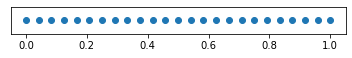

In [2]:
# Spatial resolution of mesh
N = 25

# Right limit of mesh
L = 1

# Generate 1D mesh
[nodes, elems, faces] = get_mesh_1D(N, [0,L], True);
elems = np.array(elems)[:-1,:]          # I believe there is one row too much in elems from get_mesh function

In [8]:
E=1
I=1
mu = 1
two_sided_support = True

In [12]:
# Get matrices
M_ext = get_extended_M(nodes, elems, mu)
S_ext = get_extended_S(nodes, elems, E, I, two_sided_support)
M = get_M_global(nodes, elems, mu)

# Create time array
T = 10   # end time
dt = 0.1 # time step size
times = np.arange(0, T, dt)
print(S_ext.toarray()[0, np.shape(M)[0]:])
print(S_ext.toarray()[np.shape(M)[0]:], 0)
# Initial values
w_init = np.zeros(np.shape(M)[0])
wp_init = np.zeros(np.shape(M)[0])

# FIXME: S_ext is singular, why?
sol_eigen = Eigenvalues(w0=w_init, wp0=wp_init, M=M, Me=M_ext, Se=S_ext)
w, mu = sol_eigen.solver(times)

[1. 0.]
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]] 0


RuntimeError: Factor is exactly singular